In [ ]:
# 07_Trend_Analysis_Forecasting.py
# Algerie Telecom – Trend Analysis and Forecasting
# Author: Data Engineering Team
# Date: July 2025

# %% [markdown]
# # 📈 Trend Analysis and Forecasting
# 
# Analyze historical trends and forecast future network usage patterns.
# 
# ## Objectives:
# - Identify long-term and seasonal trends
# - Analyze growth patterns by segment
# - Forecast future network capacity needs
# - Predict revenue trends
# - Identify emerging usage patterns


In [6]:
# Standard imports and setup
import sys
sys.path.append('/home/jovyan/work/batch/jupyter/notebooks/work/scripts')
from spark_init import init_spark
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
from pyspark.sql import functions as F, types as T
from pyspark.sql.window import Window
from pyspark.sql.types import *
from datetime import datetime, timedelta
import json
from pyspark.sql.functions import col, when, lit



# Initialize Spark
spark = init_spark("Trend_Analysis - AT CDR")
print("✅ SparkSession initialized")
print(f"Spark Version: {spark.version}")
print(f"Warehouse Location: {spark.conf.get('spark.sql.warehouse.dir')}")

# Use the database
spark.sql("USE at_cdr_analysis")

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create temp views
cdr_raw = spark.read.parquet("/user/hive/warehouse/Raw/raw_cdr_enhanced/")
cdr_raw.createOrReplaceTempView("fact_cdr_raw")

customers = spark.read.parquet("/user/hive/warehouse/Raw/customer_dim_enhanced/")
customers.createOrReplaceTempView("dim_customers")

print("✅ Environment ready for feature engineering")
print(f"📊 Total CDR records: {cdr_raw.count():,}")

try:
    spark.sql("DESCRIBE fact_cdr_raw").show(1)
    print("✅ ✔ fact_cdr_raw table found!")
except AnalysisException:
    raise RuntimeError("❌ fact_cdr_raw table not found! Please ingest CDR raw data first.")

# Seed for reproducibility
np.random.seed(42)
print("✅ Environment ready.\n")


ModuleNotFoundError: No module named 'statsmodels'

In [2]:


# %% [markdown]
# ## 2. Data Preparation for Time Series Analysis

# %%
print("ℹ️  Preparing daily aggregated trends from fact_cdr_raw…")

daily_trends = (
    spark.sql("""
        SELECT
            DATE(timestamp) AS date,
            COUNT(DISTINCT customer_id) AS active_customers,
            COUNT(*) AS total_cdrs,
            SUM(CASE WHEN cdr_type = 'DATA' THEN 1 ELSE 0 END) AS data_sessions,
            SUM(CASE WHEN cdr_type = 'DATA' THEN data_volume_mb ELSE 0 END) / 1024 AS total_data_gb,
            AVG(CASE WHEN cdr_type = 'DATA' THEN data_volume_mb ELSE NULL END) AS avg_session_mb,
            DAYOFWEEK(timestamp) AS day_of_week,
            WEEKOFYEAR(timestamp) AS week_of_year,
            MONTH(timestamp) AS month
        FROM fact_cdr_raw
        GROUP BY DATE(timestamp)
        ORDER BY date
    """)
    .toPandas()
)

if daily_trends.empty:
    raise RuntimeError("No rows returned for daily_trends—please check your data!")

# convert and index
daily_trends['date'] = pd.to_datetime(daily_trends['date'])
daily_trends.set_index('date', inplace=True)

print(f"✔️  Loaded {len(daily_trends)} days of data from {daily_trends.index.min().date()} to {daily_trends.index.max().date()}")
print(daily_trends[['active_customers','total_data_gb','data_sessions']].describe().round(2))



ℹ️  Preparing daily aggregated trends from fact_cdr_raw…


✔️  Loaded 122 days of data from 2025-03-20 to 2025-07-19
       active_customers  total_data_gb  data_sessions
count            122.00         122.00         122.00
mean          519647.91      999210.26     6206750.20
std             1237.33      135976.29      859938.35
min           509288.00      621795.91     3872159.00
25%           519863.00      907031.33     5584908.00
50%           519889.00      961402.93     5917724.50
75%           519910.00     1096213.82     6832297.75
max           519912.00     1238236.63     7694761.00


ℹ️  Plotting overall usage trends…


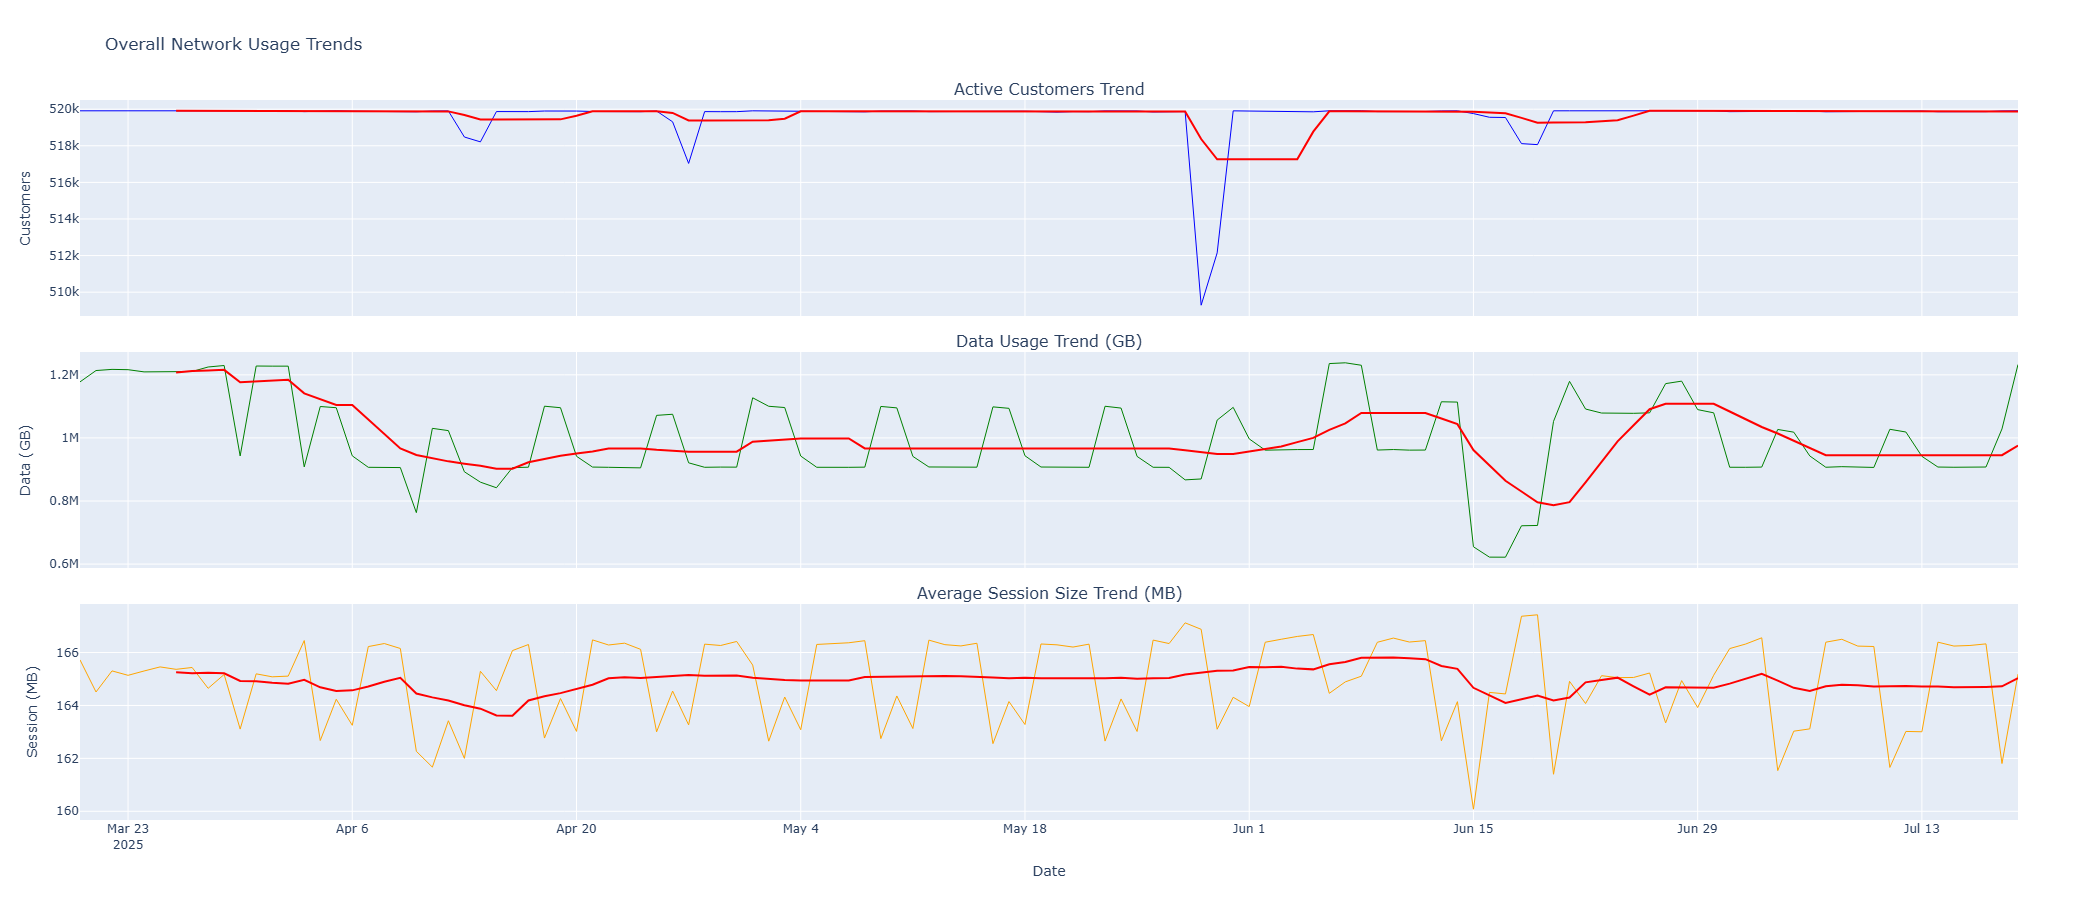

ℹ️  Computing growth metrics…

🚀 Growth Metrics:
  • Customer Growth: 0.00%
  • Data Growth: 4.68%
  • Session Growth: -0.32%


In [3]:
# ## 3. Overall Trend Analysis

# %%
print("ℹ️  Plotting overall usage trends…")

fig = make_subplots(
    rows=3, cols=1,
    subplot_titles=('Active Customers Trend','Data Usage Trend (GB)','Average Session Size Trend (MB)'),
    shared_xaxes=True, vertical_spacing=0.05
)

# 1) Active customers + 7-day MA
fig.add_trace(go.Scatter(x=daily_trends.index, y=daily_trends.active_customers,
                         mode='lines', name='Customers', line=dict(color='blue', width=1)),
              row=1, col=1)
fig.add_trace(go.Scatter(x=daily_trends.index,
                         y=daily_trends.active_customers.rolling(7).mean(),
                         mode='lines', name='7D MA', line=dict(color='red',width=2)),
              row=1, col=1)

# 2) Total data GB + 7-day MA
fig.add_trace(go.Scatter(x=daily_trends.index, y=daily_trends.total_data_gb,
                         mode='lines', name='Total Data', line=dict(color='green', width=1)),
              row=2, col=1)
fig.add_trace(go.Scatter(x=daily_trends.index,
                         y=daily_trends.total_data_gb.rolling(7).mean(),
                         mode='lines', name='7D MA', line=dict(color='red',width=2)),
              row=2, col=1)

# 3) Avg session MB + 7-day MA
fig.add_trace(go.Scatter(x=daily_trends.index, y=daily_trends.avg_session_mb,
                         mode='lines', name='Avg Session', line=dict(color='orange', width=1)),
              row=3, col=1)
fig.add_trace(go.Scatter(x=daily_trends.index,
                         y=daily_trends.avg_session_mb.rolling(7).mean(),
                         mode='lines', name='7D MA', line=dict(color='red',width=2)),
              row=3, col=1)

fig.update_layout(height=900, title_text="Overall Network Usage Trends", showlegend=False)
fig.update_xaxes(title_text="Date", row=3, col=1)
fig.update_yaxes(title_text="Customers", row=1, col=1)
fig.update_yaxes(title_text="Data (GB)", row=2, col=1)
fig.update_yaxes(title_text="Session (MB)", row=3, col=1)
fig.show()

# Compute overall growth rates
print("ℹ️  Computing growth metrics…")
grow = lambda col: (daily_trends[col].iloc[-1] / daily_trends[col].iloc[0] - 1)*100
growth_metrics = {
    'customer_growth':  grow('active_customers'),
    'data_growth':      grow('total_data_gb'),
    'session_growth':   grow('avg_session_mb')
}
print("\n🚀 Growth Metrics:")
for k,v in growth_metrics.items():
    print(f"  • {k.replace('_',' ').title()}: {v:.2f}%")



ℹ️  Performing seasonal decomposition of total_data_gb…


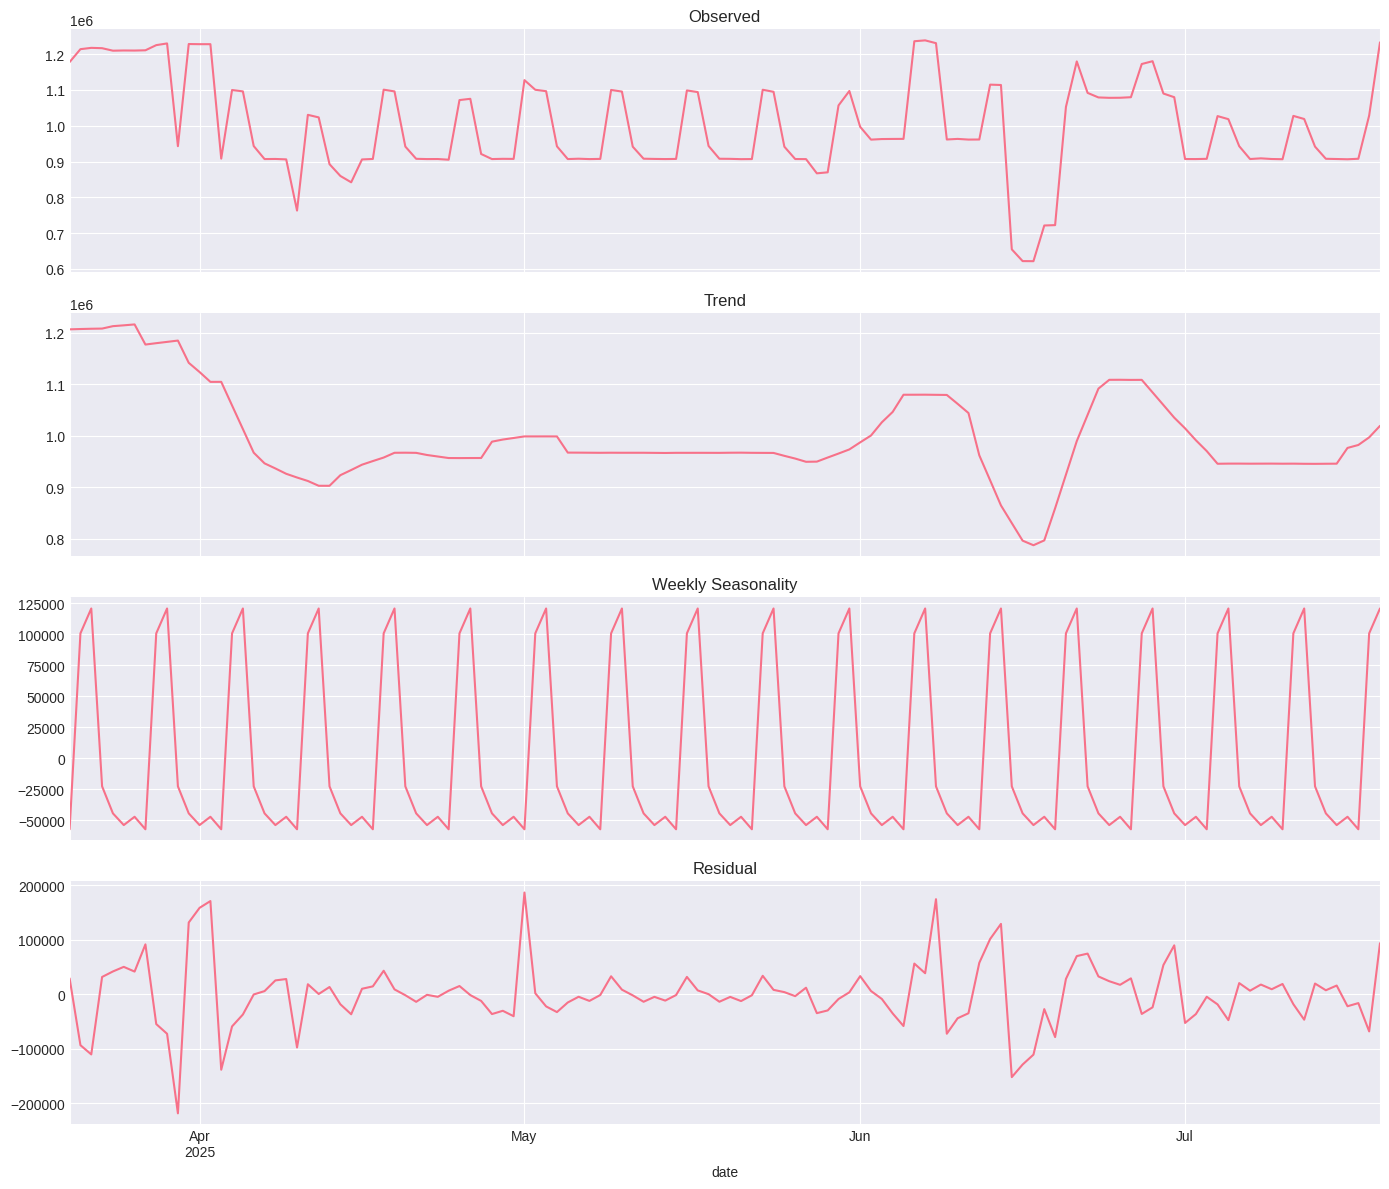


🔍 Seasonality Strength: 1.20 (Strong)


In [11]:
# 4. Seasonal Decomposition (manual)
# ----------------------------------

import numpy as np
import matplotlib.pyplot as plt

print("\nℹ️  Performing seasonal decomposition of total_data_gb…")

# 1) Trend via centered 7-day rolling mean
trend = daily_trends['total_data_gb'] \
    .rolling(window=7, center=True, min_periods=4) \
    .mean()

# 2) Detrended series
detrended = daily_trends['total_data_gb'] - trend

# 3) Weekly seasonality: average of detrended by day‐of‐week
dow       = daily_trends.index.dayofweek
seasonal  = detrended.groupby(dow).transform('mean')

# 4) Residual
resid     = daily_trends['total_data_gb'] - trend - seasonal

# Plot
fig, axes = plt.subplots(4,1,figsize=(14,12), sharex=True)
daily_trends['total_data_gb'].plot(ax=axes[0], title='Observed')
trend.plot(ax=axes[1],              title='Trend')
seasonal.plot(ax=axes[2],           title='Weekly Seasonality')
resid.plot(ax=axes[3],              title='Residual')
plt.tight_layout()
plt.show()

# Seasonality strength
seasonality_strength = np.std(seasonal.dropna()) / np.std(resid.dropna())
print(f"\n🔍 Seasonality Strength: {seasonality_strength:.2f} "
      f"({'Strong' if seasonality_strength > 1 else 'Weak'})")



ℹ️  Analyzing data usage trends by service_type…


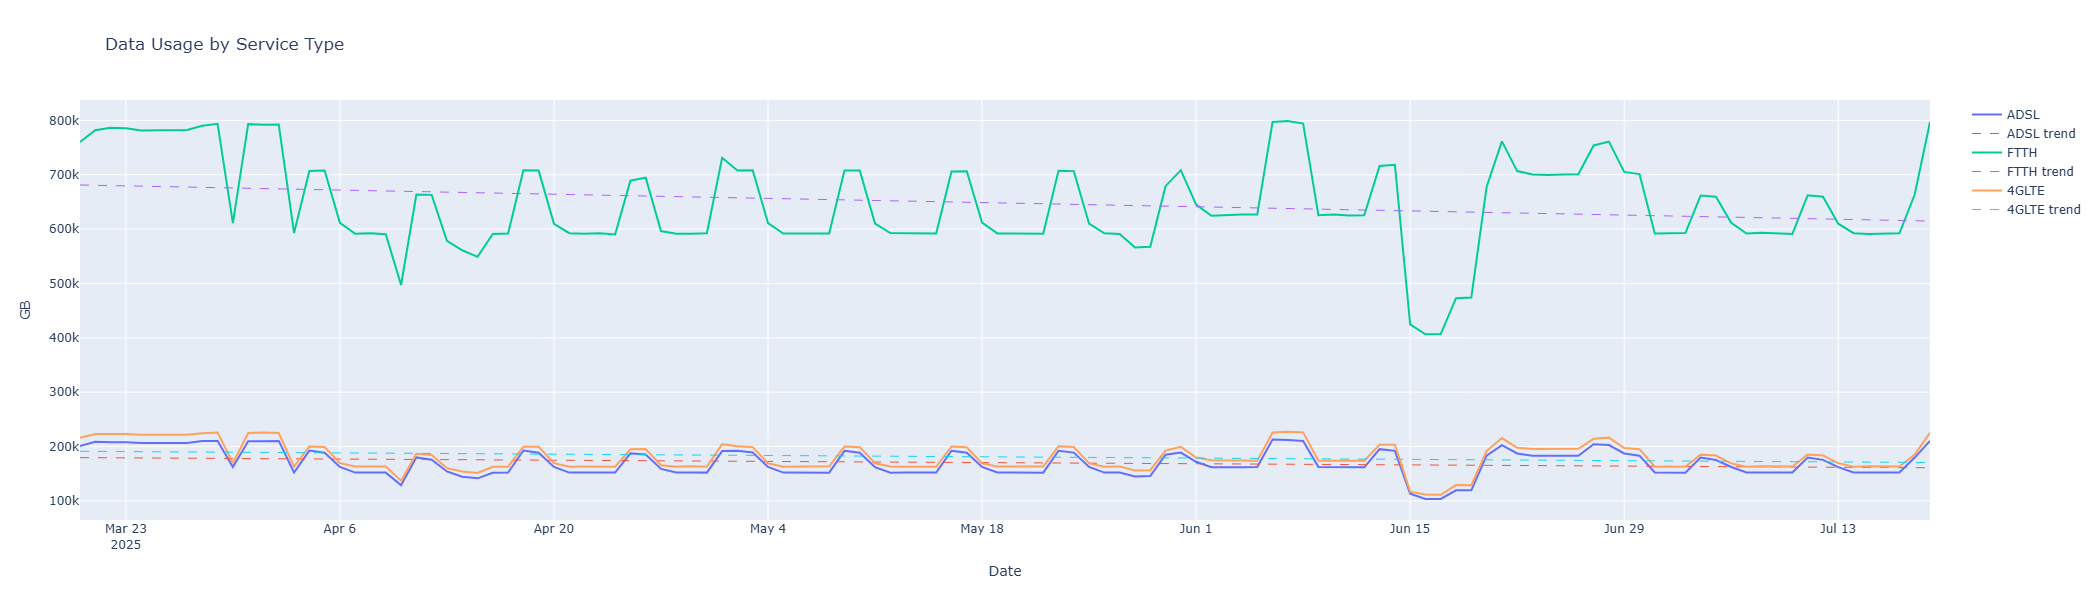


📊 Service Growth in Last 30 Days:
  • ADSL: -4.73%
  • FTTH: -4.39%
  • 4GLTE: -5.16%


In [8]:
# ## 5. Service Type Trend Analysis

# %%
print("\nℹ️  Analyzing data usage trends by service_type…")

svc = (
    spark.sql("""
      SELECT
         DATE(timestamp) AS date,
         service_type,
         SUM(CASE WHEN cdr_type='DATA' THEN data_volume_mb ELSE 0 END)/1024 AS total_data_gb
      FROM fact_cdr_raw
      GROUP BY DATE(timestamp), service_type
      ORDER BY date
    """)
    .toPandas()
)
if svc.empty:
    print("⚠️ no service_type CDR rows found, skipping…")
else:
    svc['date'] = pd.to_datetime(svc.date)
    pivot = svc.pivot(index='date', columns='service_type', values='total_data_gb').fillna(0)
    fig = go.Figure()
    xnum = np.arange(len(pivot))
    for svc_type in ['ADSL','FTTH','4GLTE']:
        if svc_type in pivot:
            y = pivot[svc_type]
            fig.add_trace(go.Scatter(x=pivot.index, y=y, mode='lines', name=svc_type, line=dict(width=2)))
            z = np.polyfit(xnum, y.values, 1)
            fig.add_trace(go.Scatter(x=pivot.index, y=np.poly1d(z)(xnum),
                                     mode='lines', name=f'{svc_type} trend', 
                                     line=dict(dash='dash', width=1)))
    fig.update_layout(title='Data Usage by Service Type', xaxis_title='Date', yaxis_title='GB', height=600)
    fig.show()

    print("\n📊 Service Growth in Last 30 Days:")
    for svc_type in ['ADSL','FTTH','4GLTE']:
        if svc_type in pivot:
            start = pivot[svc_type].iloc[:30].mean()
            end   = pivot[svc_type].iloc[-30:].mean()
            print(f"  • {svc_type}: {((end/start)-1)*100:.2f}%")



ℹ️  Comparing growth across major wilayas…


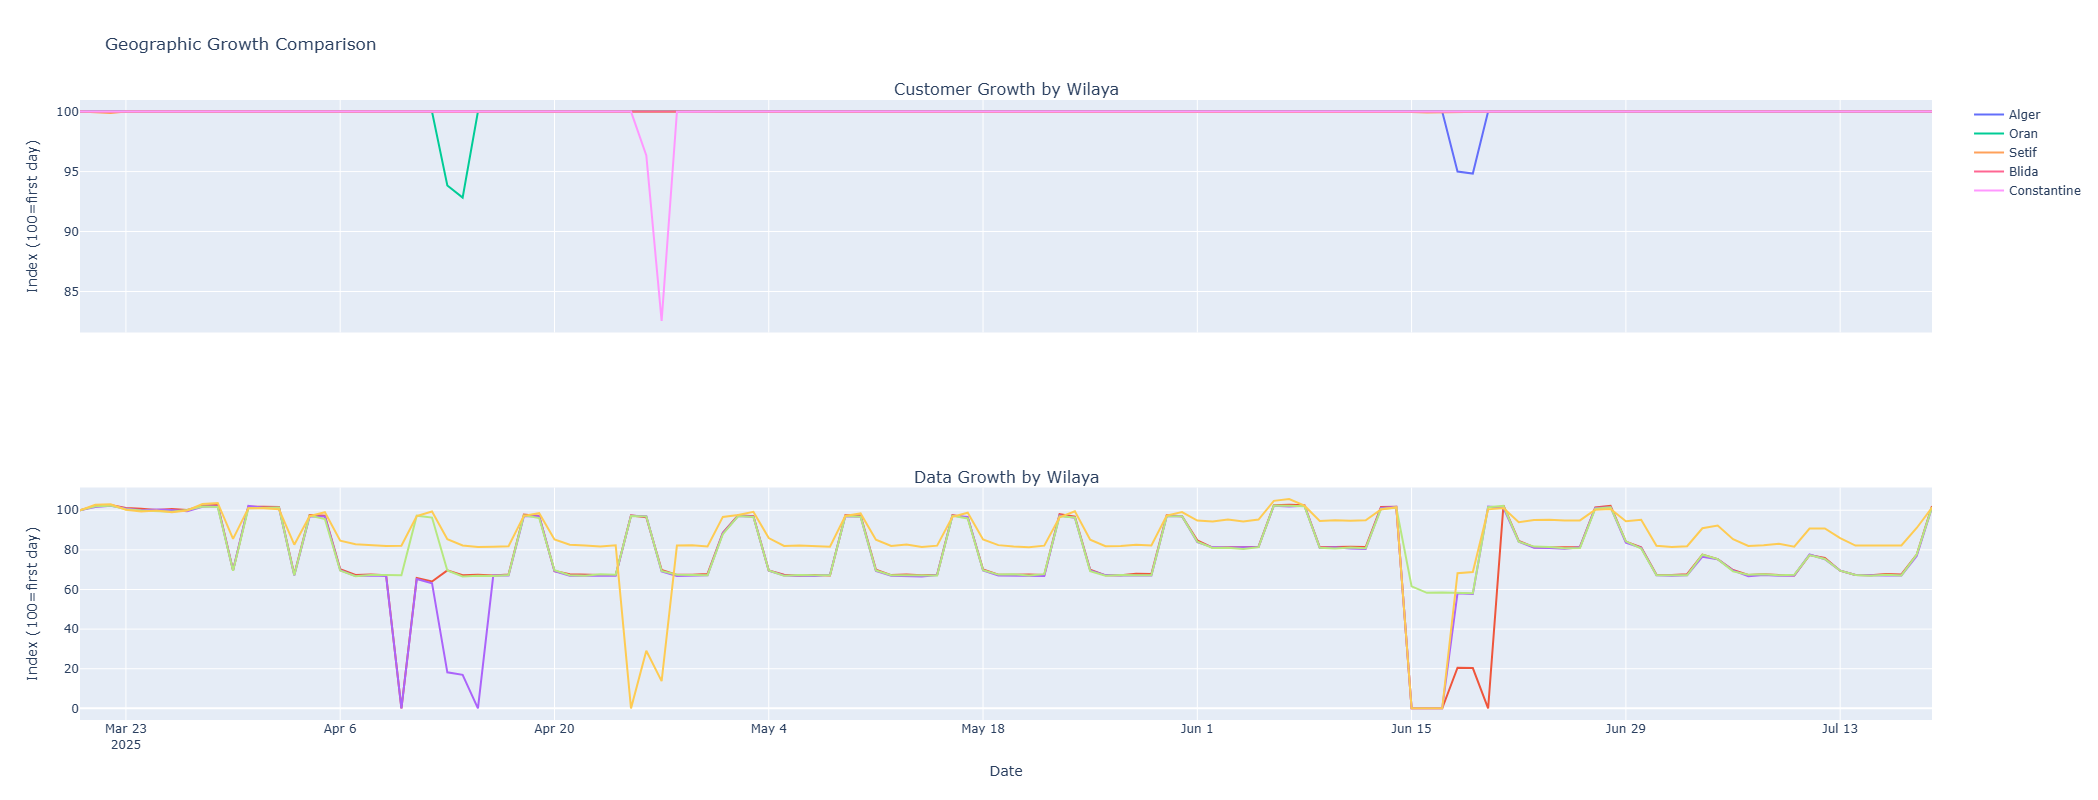

In [9]:
# ## 6. Geographic Trend Analysis

# %%
print("\nℹ️  Comparing growth across major wilayas…")
geo = (
    spark.sql("""
      SELECT
        DATE(timestamp) AS date,
        wilaya_code, wilaya_name,
        SUM(CASE WHEN cdr_type='DATA' THEN data_volume_mb ELSE 0 END)/1024 AS total_data_gb,
        COUNT(DISTINCT customer_id) AS active_customers
      FROM fact_cdr_raw
      WHERE wilaya_code IN ('16','31','25','19','09')
      GROUP BY DATE(timestamp), wilaya_code, wilaya_name
      ORDER BY date
    """)
    .toPandas()
)
if geo.empty:
    print("⚠️ no rows for top wilayas found, skipping…")
else:
    geo['date']=pd.to_datetime(geo.date)
    fig = make_subplots(rows=2, cols=1,
                        subplot_titles=('Customer Growth by Wilaya','Data Growth by Wilaya'),
                        shared_xaxes=True)
    for code in geo.wilaya_code.unique():
        df = geo[geo.wilaya_code==code].set_index('date')
        idx = df.active_customers.iloc[0]
        jdx = df.total_data_gb.iloc[0]
        fig.add_trace(go.Scatter(x=df.index, y=df.active_customers/idx*100, name=df.wilaya_name.iloc[0]),
                      row=1, col=1)
        fig.add_trace(go.Scatter(x=df.index, y=df.total_data_gb/jdx*100, showlegend=False),
                      row=2, col=1)
    fig.update_yaxes(title_text="Index (100=first day)", row=1, col=1)
    fig.update_yaxes(title_text="Index (100=first day)", row=2, col=1)
    fig.update_xaxes(title_text="Date", row=2, col=1)
    fig.update_layout(height=800, title="Geographic Growth Comparison")
    fig.show()


In [17]:
pip install neuralprophet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 46.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 116.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 118.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 136.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 115.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14/14 [neuralprophet]0m [pytorch-lightning]
Note: you may need to restart the kernel to use updated packages.


In [26]:
pip install plotly-resampler


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 45.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 26.9 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.2 MB/s eta 0:00:00
  Attempting uninstall: blinker
    Found existing installation: blinker 1.6.3
    Uninstalling blinker-1.6.3:
      Successfully uninstalled blinker-1.6.3
  Attempting uninstall: plotly
    Found existing installation: plotly 6.1.2
    Uninstalling plotly-6.1.2:━━━╺━━━━━━━━━━━━━━  7/11 [plotly]
      Successfully uninstalled plotly-6.1.2━━━━━━━━━━━━━━  7/11 [plotly]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11/11 [plotly-resampler][dash]]]
Note: you may need to restart the kernel to use updated packages.


In [25]:
pip install plotly 

ERROR: Could not find a version that satisfies the requirement plotyl-resampler (from versions: none)
ERROR: No matching distribution found for plotyl-resampler
Note: you may need to restart the kernel to use updated packages.


INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.



ℹ️  Training NeuralProphet on total_data_gb…


INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.18% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (NP.forecaster.fit) - Changing n_forecasts to 1. Without lags, the forecast can be computed for any future time, independent of lagged values
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 230


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.18% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - /opt/conda/lib/python3.11/site-packages/neuralprophet/data/split.py:273: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.187% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.187% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
ERROR - (NP.plotly.plot) - plotly-resampler is not installed. Please install it to use the resampler.
WARNING - (py.warnings._showwarnmsg) - /opt/conda/lib/python3.11/site-packages/neuralprophet/plot_forecast_plotly.py:100: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result




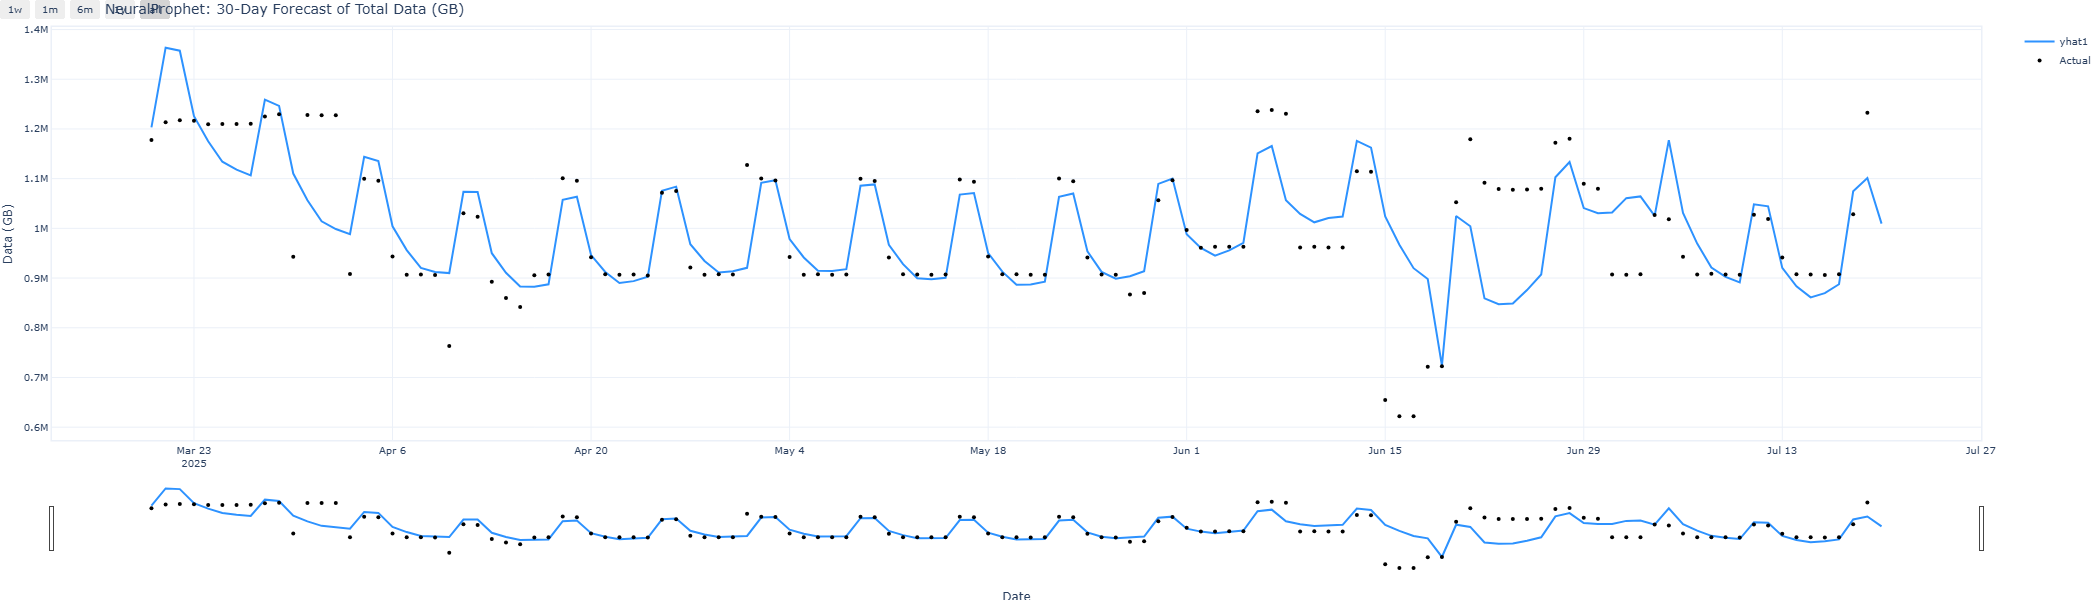

ERROR - (NP.plotly.plot_components) - plotly-resampler is not installed. Please install it to use the resampler.
WARNING - (py.warnings._showwarnmsg) - /opt/conda/lib/python3.11/site-packages/neuralprophet/plot_forecast_plotly.py:410: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result




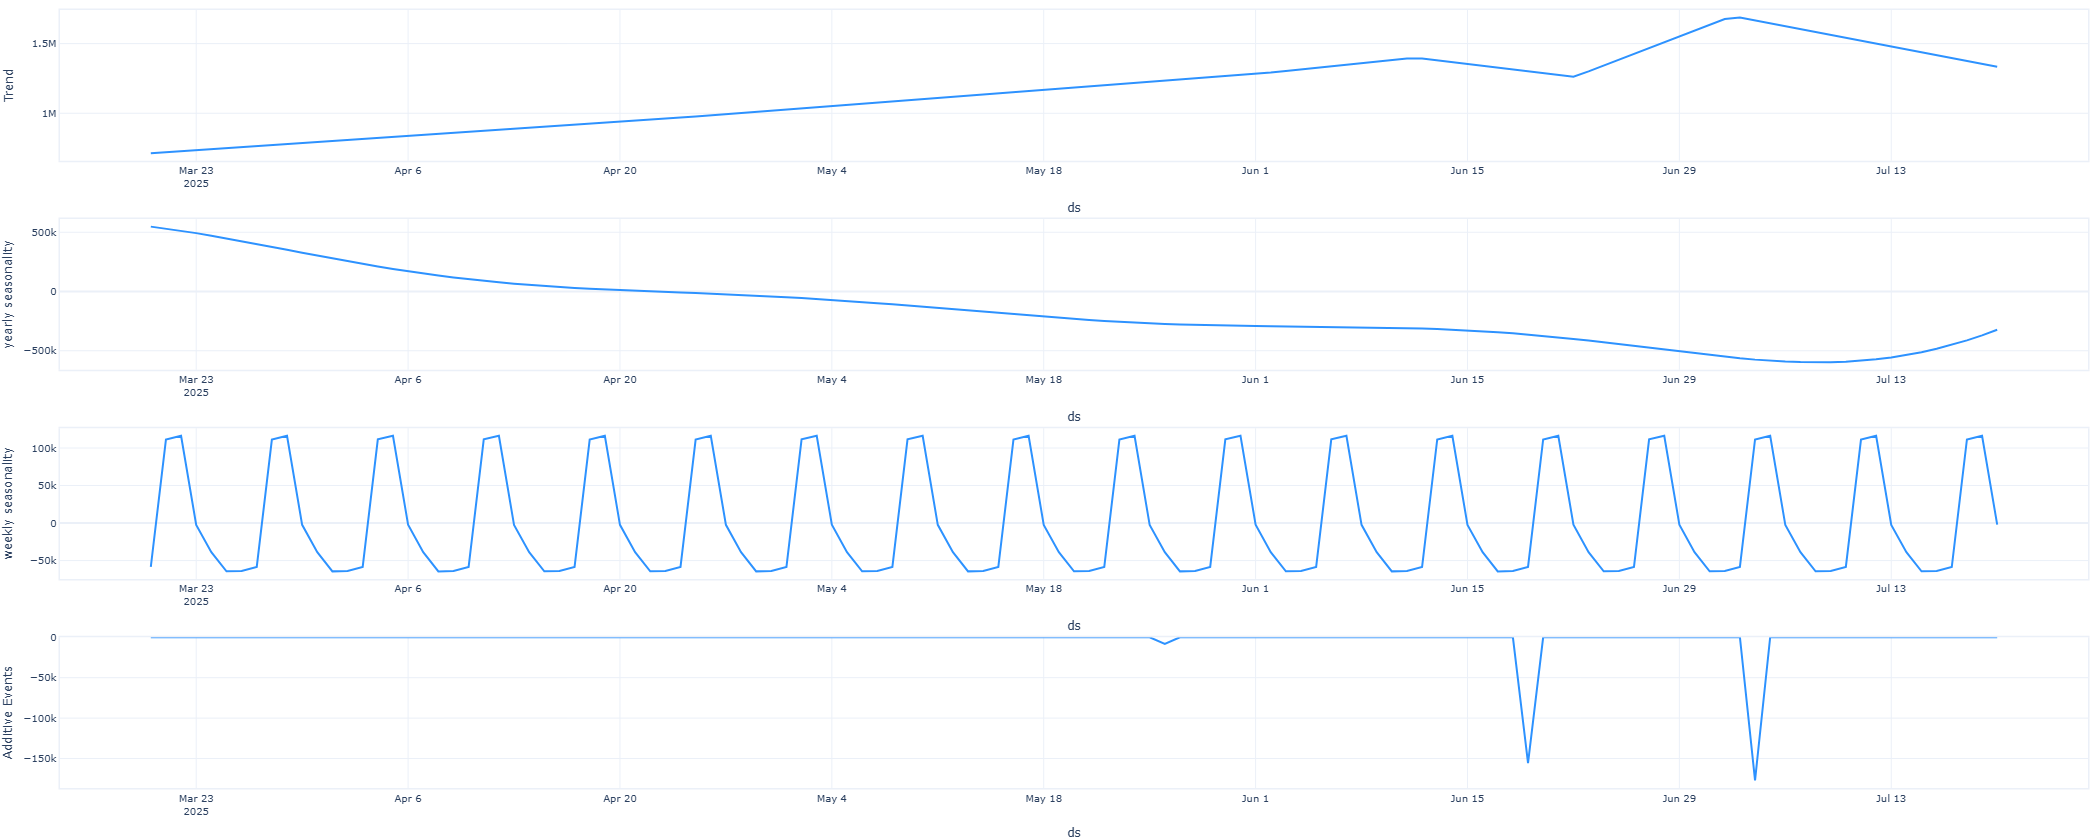

In [27]:
# Cell 7 — NeuralProphet Forecast

# 1) Import
from neuralprophet import NeuralProphet

print("\nℹ️  Training NeuralProphet on total_data_gb…")

# 2) Prepare data (assumes you already have ts = pd.DataFrame with columns ds/y)

# 3) Instantiate & configure model
m_np = NeuralProphet(
    n_forecasts=30,               # number of days ahead to forecast
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,      # disable if no sub‐daily pattern
    changepoints_range=0.95,      # allow changepoints up to 95% of history
    trend_reg=5,                  # strength of trend regularization
    seasonality_reg=1,            # strength of seasonality regularization
    learning_rate=1.0,            # default
)

# 4) (Optional) Add built-in country holidays or a custom regressor:
m_np = m_np.add_country_holidays(country_name='US')
# m_np = m_np.add_regressor(name='is_ramdhan')

# 5) Fit the model
metrics = m_np.fit(ts, freq='D')  # 'D' = daily frequency

# 6) Make future dataframe & forecast
future_np = m_np.make_future_dataframe(ts, n_historic_predictions=True)
forecast_np = m_np.predict(future_np)

# 7) Plot the forecasts
fig_np = m_np.plot(forecast_np)
fig_np.update_layout(
    title="NeuralProphet: 30-Day Forecast of Total Data (GB)",
    xaxis_title="Date",
    yaxis_title="Data (GB)",
    height=600
)
fig_np.show()

# 8) Plot the components
fig_comp_np = m_np.plot_components(forecast_np)
fig_comp_np.show()


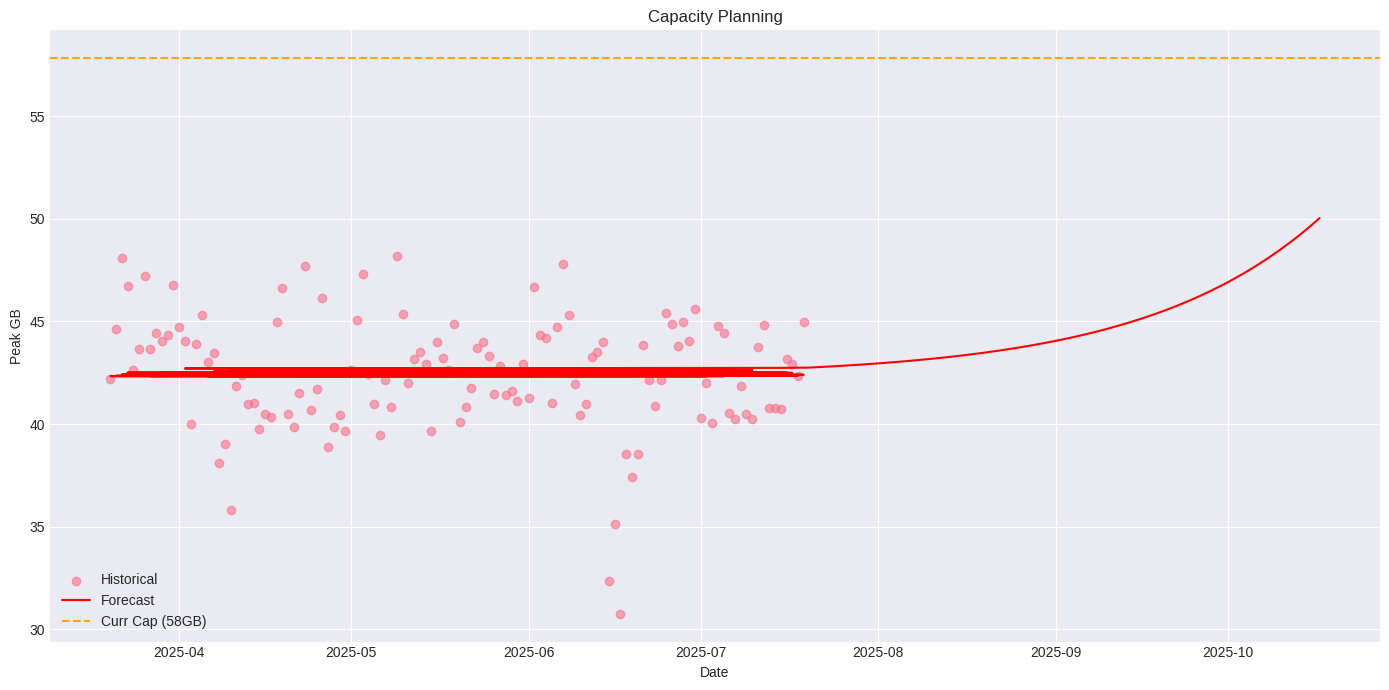


Current peak: 48 GB
30-day forecast: 43 GB


In [29]:
# ...
future_x = np.arange(len(peak)+90)
forecast_y = exp_func(future_x, *popt)

# Turn both into Series before concatenating
hist_dates = peak.date.reset_index(drop=True)
proj_dates = pd.Series(
    pd.date_range(peak.date.max() + pd.Timedelta(days=1), periods=90),
    name='date'
)

all_dates = pd.concat([hist_dates, proj_dates], ignore_index=True)

plt.figure(figsize=(14,7))
plt.scatter(hist_dates, y, alpha=0.6, label='Historical')
plt.plot(all_dates, forecast_y, 'r-', label='Forecast')

current_cap = y.max() * 1.2
plt.axhline(current_cap, color='orange', linestyle='--',
            label=f'Curr Cap ({current_cap:.0f}GB)')

idxs = np.where(forecast_y > current_cap)[0]
if len(idxs):
    exd = all_dates.iloc[idxs[0]]
    plt.axvline(exd, color='red', linestyle=':', alpha=0.7)
    plt.text(exd, current_cap*1.1, f'Exceeded {exd.date()}',
             rotation=90, va='bottom')

plt.legend()
plt.title('Capacity Planning')
plt.xlabel('Date')
plt.ylabel('Peak GB')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"\nCurrent peak: {y.max():.0f} GB")
print(f"30-day forecast: {forecast_y[len(peak)+30]:.0f} GB")
if len(idxs):
    days_to = (all_dates.iloc[idxs[0]] - peak.date.max()).days
    print(f"⚠️ Capacity will be exceeded in ~{days_to} days")
